### Bibliotecas
Bibliotecas utilizadas ao longo deste notebook

In [80]:
import pandas as pd
import numpy as np
from glob import glob
from functools import reduce
import math
from collections import Counter
import matplotlib.pyplot as plt
import scipy

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


### O problema dos NaNs

Nesse estudo, nosso objetivo central é a utilização dos dados da estação meterológica de Congonhas. Porém, identificamos vários horários com valores NaNs, ou seja, horários onde não há medições nos sensores.

Veja um exemplo de falhas na série temporal no sensor de Monóxido de Carbono.

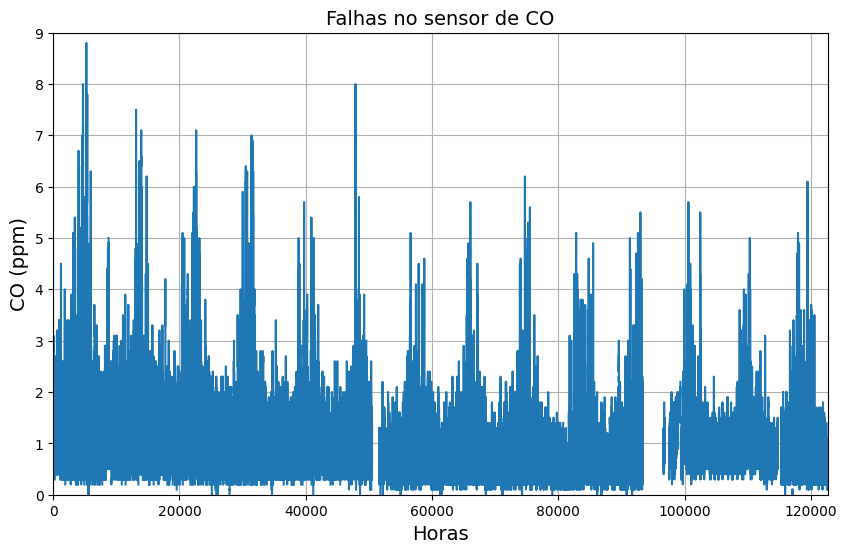

In [117]:
df = pd.read_csv('congonhas/Dataset-CETESB-Final-Congonhas.csv', delimiter=';')
df = df.drop(columns=['Unnamed: 0'])


fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df.index, df['CO(Monóxido de Carbono) - ppm'], markersize=8)
plt.xlim(0, 122735)
plt.ylim(0, 9)
plt.title('Falhas no sensor de CO', fontsize=14)
plt.ylabel('CO (ppm)', fontsize=14)
plt.xlabel('Horas', fontsize=14)
plt.grid(True)
plt.show()

In [114]:
df

,Data,Hora,CO(Monóxido de Carbono) - ppm,MP10(Partículas Inaláveis) - µg/m3,MP2.5(Partículas Inaláveis Finas) - µg/m3,NO(Monóxido de Nitrogênio) - µg/m3,NO2(Dióxido de Nitrogênio) - µg/m3,NOx(Óxidos de Nitrogênio) - ppb,O3(Ozônio) - µg/m3,SO2(Dióxido de Enxofre) - µg/m3
0,01/01/2011,01:00,0.6,36.0,15.0,NaN,NaN,NaN,NaN,8.0
1,01/01/2011,02:00,0.8,67.0,44.0,22.0,25.0,31.0,NaN,8.0
2,01/01/2011,03:00,0.7,46.0,34.0,16.0,23.0,25.0,NaN,5.0
3,01/01/2011,04:00,0.6,21.0,14.0,9.0,23.0,19.0,NaN,NaN
4,01/01/2011,05:00,NaN,14.0,6.0,7.0,20.0,16.0,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...
122731,31/12/2024,20:00,0.7,19.0,22.0,21.0,59.0,49.0,NaN,1.0
122732,31/12/2024,21:00,0.6,31.0,15.0,16.0,54.0,42.0,NaN,1.0
122733,31/12/2024,22:00,0.6,16.0,17.0,2.0,31.0,18.0,NaN,0.0
122734,31/12/2024,23:00,0.7,36.0,30.0,2.0,28.0,16.0,NaN,0.0


A partir desse impasse resolvemos, antes de adotar qualquer estratégia de imput em dados, fazer uma análise exploratória sobre a quantidade de valores NaNs presentes em cada coluna do dataset.

In [82]:
# Contagem de valores NaNs

df.isna().sum()

Data                                              0
Hora                                              0
CO(Monóxido de Carbono) - ppm                 13781
MP10(Partículas Inaláveis) - µg/m3             6075
MP2.5(Partículas Inaláveis Finas) - µg/m3      8523
NO(Monóxido de Nitrogênio) - µg/m3            15299
NO2(Dióxido de Nitrogênio) - µg/m3            15299
NOx(Óxidos de Nitrogênio) - ppb               15299
O3(Ozônio) - µg/m3                           122736
SO2(Dióxido de Enxofre) - µg/m3               18204
dtype: int64

Abaixo segue funções auxiliares para análise análise mais detalhadas sobre as faltas dos valores NaNs, se são consecutivos ou não, porcentagem de faltas e atc. Chame esta função em qualquer neste notebook p/ tais análises.

In [32]:
def analise_frequentista_nan(df):
    """
    Análise frequentista das sequências de NaN no DataFrame
    """
    print("=== ANÁLISE FREQUENTISTA DE SEQUÊNCIAS NaN ===\n")
    
    for coluna in df.columns:
        if df[coluna].isna().any():
            sequencias = contar_sequencias_nan(df[coluna])
            
            if sequencias:
                freq = Counter(sequencias)
                total_sequencias = len(sequencias)
                
                print(f"Coluna '{coluna}':")
                print(f"Total de sequências: {total_sequencias}")
                print(f"Tamanhos encontrados: {sorted(freq.keys())}")
                
                for tamanho in sorted(freq.keys()):
                    count = freq[tamanho]
                    porcentagem = (count / total_sequencias) * 100
                    print(f"  {tamanho} NaN consecutivo(s): {count} vez(es) ({porcentagem:.1f}%)")
                
                max_seq = max(sequencias)
                min_seq = min(sequencias)
                avg_seq = sum(sequencias) / len(sequencias)
                
                print(f"  Maior sequência: {max_seq} NaN(s)")
                print(f"  Menor sequência: {min_seq} NaN(s)")
                print(f"  Média: {avg_seq:.2f} NaN(s) por sequência")
                print("-" * 50)
    
    print("\n=== ANÁLISE GERAL DO DATAFRAME ===")
    
    todas_sequencias = []
    for coluna in df.columns:
        sequencias = contar_sequencias_nan(df[coluna])
        todas_sequencias.extend(sequencias)
    
    if todas_sequencias:
        freq_geral = Counter(todas_sequencias)
        total_geral = len(todas_sequencias)
        
        print(f"Total de sequências no DataFrame: {total_geral}")
        print(f"Tamanhos encontrados: {sorted(freq_geral.keys())}")
        
        print("\nFrequência geral:")
        for tamanho in sorted(freq_geral.keys()):
            count = freq_geral[tamanho]
            porcentagem = (count / total_geral) * 100
            print(f"  {tamanho} NaN consecutivo(s): {count} vez(es) ({porcentagem:.1f}%)")
        
        print(f"\nEstatísticas gerais:")
        print(f"  Maior sequência: {max(todas_sequencias)} NaN(s)")
        print(f"  Menor sequência: {min(todas_sequencias)} NaN(s)")
        print(f"  Média geral: {sum(todas_sequencias)/len(todas_sequencias):.2f} NaN(s) por sequência")

In [33]:
def contar_sequencias_nan(coluna):
    """
    Identifica todas as sequências de NaN e retorna seus tamanhos
    """
    sequencias = []
    i = 0
    n = len(coluna)
    
    while i < n:
        if pd.isna(coluna.iloc[i]):
            count = 1
            j = i + 1
            while j < n and pd.isna(coluna.iloc[j]):
                count += 1
                j += 1
            sequencias.append(count)
            i = j 
        else:
            i += 1
    
    return sequencias

In [16]:
# analise_frequentista_nan(df)

### Resolvendo o problema do NaNs

1° Estratégia: Se houver um valor NaN, substituí-lo com a média das estações vizinhas (e com características físicas/urbanas similares): Santo Amaro e Mooca.
Para isso, criamos um dataset auxiliar com a média dessas duas estações. Os critérios foram os seguintes:
Para cada horário da série temporal olhamos os dados doa sensores das duas estações: Santo Amaro e Mooca, caso ambas o tenham realizamos a média. Caso apenas uma estações tenha dados a adicionamos. E por fim, caso nenhuma delas tenha dados, o valor NaN permanece.

Abaixo estão os códigos utilizados para tal.

In [118]:
# carregando os dfs das diferentes estações meteorógicas

df_mooca = pd.read_csv('mooca/Dataset-CETESB-Final-Mooca.csv', delimiter=';')
df_santo = pd.read_csv('Santo_Amaro/Dataset-CETESB-Final-SantoAmaro.csv', delimiter=';')
df_congonhas = pd.read_csv('congonhas/Dataset-CETESB-Final-Congonhas.csv', delimiter=';')

In [119]:
# Escluindo as colunas que não existem em Congonhas

df_mooca = df_mooca.drop(columns = ['Unnamed: 0', 'DV(Direção do Vento) - °', 'DVG(Direção do Vento Global) - °', 'VV(Velocidade do Vento) - m/s'])
df_santo = df_santo.drop(columns = ['Unnamed: 0', 'DV(Direção do Vento) - °', 'DVG(Direção do Vento Global) - °', 'VV(Velocidade do Vento) - m/s'])

In [85]:
df_media_samo = df_santo.copy()

colunas_mooca = list(df_mooca.columns)[2:]
colunas_mooca

for i in colunas_mooca:
    for j in range(len(df_mooca[i])):
        if math.isnan(df_mooca[i][j]) and math.isnan(df_santo[i][j]):
            df_media_samo.loc[j,i] = df_santo.loc[j,i]
        else:
            df_media_samo.loc[j,i] = np.nanmean([df_mooca[i][j], df_santo[i][j]])
            

In [86]:
# Salvando em um arquivo .csv

df_media_samo = df_media_samo.to_csv('Dataset-CETESB-Media-SaMo.csv', sep=';')

Agora, esse arquivo auxiliar facilitará a comparação de datasets. Veja, no código abaixo comparamos cada item dos datasets, em casos de faltas no dataset de Congonhas as substituímos com dados do dataset de média SaMo. Em casos de NaNs em ambos os datasets o NaN permanece.

In [120]:
df_media_samo = pd.read_csv('Dataset-CETESB-Media-SaMo.csv', sep=';')
df_media_samo = df_media_samo.drop(columns=['Unnamed: 0'])
# df_media_samo

In [92]:
# Substituindo com o SaMo os dados faltantes de Congonhas

colunas_samo = list(df_media_samo.columns)[2:]

for i in colunas_samo:
    for j in range(len(df_media_samo[i])):
        if math.isnan(df_congonhas[i][j]) and not math.isnan(df_media_samo[i][j]):
            df_congonhas.loc[j,i] = df_media_samo.loc[j,i]
            

In [93]:
# Salvando o trabalho em um .csv

df_congonhas = df_congonhas.to_csv('Dataset-CETESB-Congonhas-Vizinhos.csv', sep=';')

Veja no gráfico as substituições para o caso do sensor de Monóxido de Carbono.

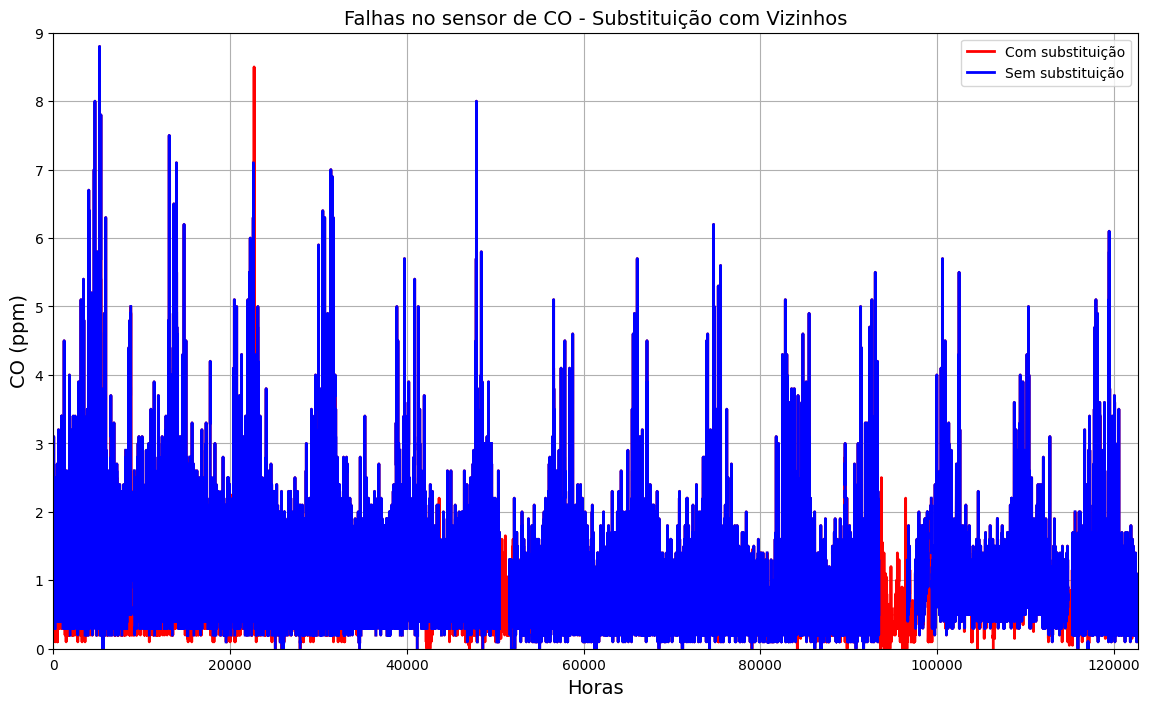

In [121]:
# Platando um gráfico p/ ver onde houve a substituição foi feita de maneira visual

df_congonhas = pd.read_csv('congonhas/Dataset-CETESB-Final-Congonhas.csv', sep=';')
df_congonhas = df_congonhas.drop(columns=['Unnamed: 0'])

df_congonhas_final = pd.read_csv('Dataset-CETESB-Congonhas-Vizinhos.csv', sep=';')
df_congonhas_final = df_congonhas_final.drop(columns=['Unnamed: 0'])


fig, ax = plt.subplots(figsize=(14, 8))


# primeira linha de plot
ax.plot(df_congonhas.index.values, df_congonhas_final['CO(Monóxido de Carbono) - ppm'].values,
        'r-', linewidth=2, markersize=4, label='Com substituição')

# segunda linha de plot
ax.plot(df_congonhas.index.values, df_congonhas['CO(Monóxido de Carbono) - ppm'].values, 
        'b-', linewidth=2, markersize=4, label='Sem substituição')

plt.xlim(0, 122735)
plt.ylim(0, 9)
plt.grid(True)
plt.ylabel('CO (ppm)', fontsize=14)
plt.xlabel('Horas', fontsize=14)
plt.title('Falhas no sensor de CO - Substituição com Vizinhos', fontsize=14)
plt.legend()  # Mostra a legenda
plt.show()

In [97]:
df_congonhas_final.isna().sum()

Unnamed: 0.1                                     0
Data                                             0
Hora                                             0
CO(Monóxido de Carbono) - ppm                 1195
MP10(Partículas Inaláveis) - µg/m3            1067
MP2.5(Partículas Inaláveis Finas) - µg/m3     4353
NO(Monóxido de Nitrogênio) - µg/m3           15299
NO2(Dióxido de Nitrogênio) - µg/m3           15299
NOx(Óxidos de Nitrogênio) - ppb              15299
O3(Ozônio) - µg/m3                            4420
SO2(Dióxido de Enxofre) - µg/m3              18204
dtype: int64

Repetindo a análise do número e seguência de NaNs. 

In [7]:
# analise_frequentista_nan(df_congonhas_final)

Vimos que o número de NaNs reduziu bastante. Mas ainda sobraram alguns desses valores. Nesse restante vamos utilizar a técnica de interpolação (pelo método nearest) de dados.

In [122]:
# tirando data e hora
atributos = list(df_congonhas_final.columns)[2:]
 
#Interpola os atributos
for i in atributos:
    df_congonhas_final[i] = df_congonhas_final[i].interpolate(method = "nearest")


C:\Users\geovana23021\AppData\Local\Temp\ipykernel_20536\1765762504.py:6: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_congonhas_final[i] = df_congonhas_final[i].interpolate(method = "nearest")


Mas uma vez, vamos visualizar graficamente o preenchimento dos NaNs.

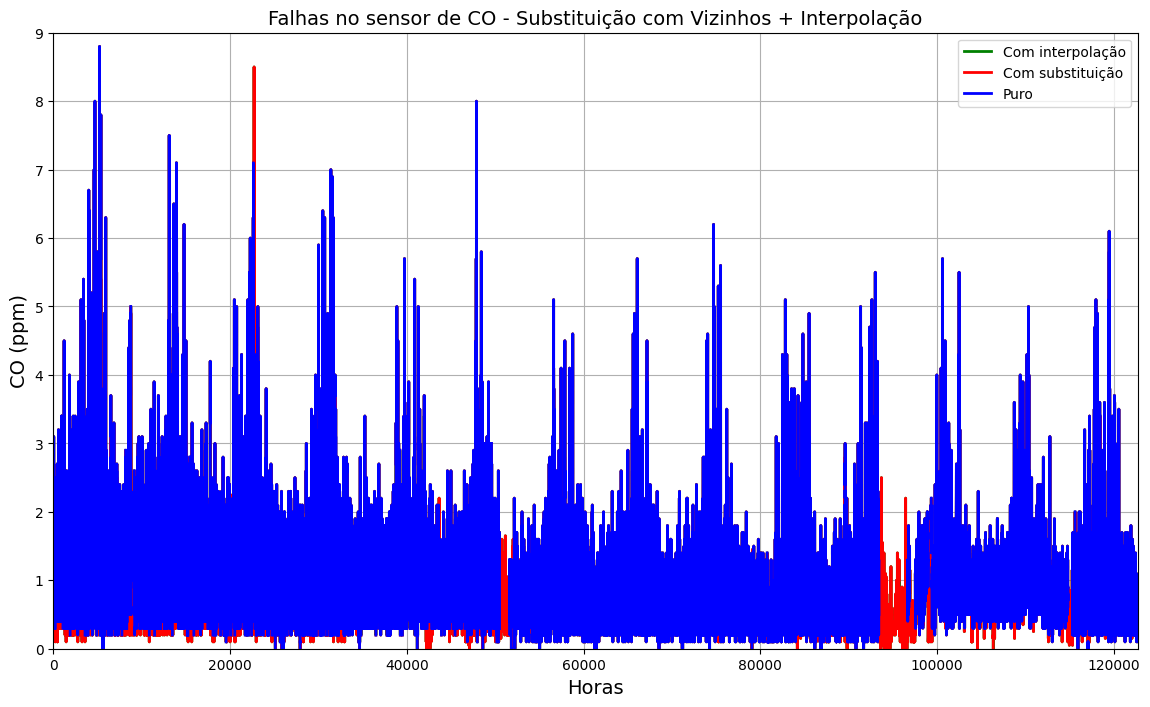

In [128]:
# Platando um gráfico p/ ver onde houve a substituição foi feita de maneira visual

df_congonhas = pd.read_csv('congonhas/Dataset-CETESB-Final-Congonhas.csv', sep=';')
df_congonhas = df_congonhas.drop(columns=['Unnamed: 0'])

df_congonhas_samo = pd.read_csv('Dataset-CETESB-Congonhas-Vizinhos.csv', sep=';')
df_congonhas_samo = df_congonhas_samo.drop(columns=['Unnamed: 0'])


fig, ax = plt.subplots(figsize=(14, 8))

# primeira linha
ax.plot(df_congonhas.index.values, df_congonhas_final['CO(Monóxido de Carbono) - ppm'].values,
        'g-', linewidth=2, markersize=4, label='Com interpolação')

# segunda linha
ax.plot(df_congonhas.index.values, df_congonhas_samo['CO(Monóxido de Carbono) - ppm'].values,
        'r-', linewidth=2, markersize=4, label='Com substituição')

# terceira linha
ax.plot(df_congonhas.index.values, df_congonhas['CO(Monóxido de Carbono) - ppm'].values, 
        'b-', linewidth=2, markersize=4, label='Puro')


plt.xlim(0, 122735)
plt.ylim(0, 9)
plt.grid(True)
plt.ylabel('CO (ppm)', fontsize=14)
plt.xlabel('Horas', fontsize=14)
plt.title('Falhas no sensor de CO - Substituição com Vizinhos + Interpolação', fontsize=14)
plt.legend()  # Mostra a legenda
plt.show()

Salvando em um .csv de nome "Dataset-CETESB-Congonhas-OFICIAL.csv" - Este arquivo possui os dados de Congonhas como os principais, depois há a substituição dos NaNs com a média de Santo Amaro + Mooca e para o restante de NaNs interpola com o método de nearest.

In [112]:
df_congonhas_final = df_congonhas_final.to_csv('Dataset-CETESB-Congonhas-OFICIAL.csv', sep=';')

Ops! Já ia me esquecendo de um detalhe muuuito importante. Nesse trabalho vamos lidar com dados diários, então precisamos resolver isso.

In [129]:
df = pd.read_csv('Dataset-CETESB-horarios.csv', delimiter=';')
df = df.drop(columns=['Unnamed: 0'])
df = df.drop(columns=['Hora'])

Conversão de tipo de dados, necessária p/ as próximas ações.

In [130]:
# transformando p/ o padrão de datas do pandas
# mes/dia/ano

df['Data'] = pd.to_datetime(df['Data'], dayfirst = True)

Usamos a mediana diária como operação de agregação.

In [132]:
# Pegando a mediana do diária, agora cada dia tem uma único valor de atributo

atributos = list(df.columns)[1:]

medianas = []

for i in atributos:

    mediana_diaria = df.groupby(df['Data'].dt.date)[i].median()

    mediana_diaria = mediana_diaria.to_frame()

    medianas.append(mediana_diaria.reset_index(drop=True))

# df agora é dados, c/ as correções
dados = pd.concat(medianas, axis = 1)

dados["Data"] = pd.Series(df["Data"].dt.date.unique())

In [133]:
dados['Data'] = pd.to_datetime(dados['Data'])
dados

,Data,CO(Monóxido de Carbono) - ppm,MP10(Partículas Inaláveis) - µg/m3,MP2.5(Partículas Inaláveis Finas) - µg/m3,NO(Monóxido de Nitrogênio) - µg/m3,NO2(Dióxido de Nitrogênio) - µg/m3,NOx(Óxidos de Nitrogênio) - ppb,O3(Ozônio) - µg/m3,SO2(Dióxido de Enxofre) - µg/m3
0,2011-01-01,0.70,15.5,7.0,20.5,26.0,30.5,35.5,5.0
1,2011-01-02,0.85,10.0,4.5,35.0,25.0,44.5,19.5,2.0
2,2011-01-03,1.15,13.0,9.5,41.0,39.0,55.5,7.5,2.0
3,2011-01-04,0.95,12.5,9.0,31.5,33.0,45.5,8.0,1.0
4,2011-01-05,1.20,18.0,11.5,34.5,41.0,52.0,23.5,4.0
...,...,...,...,...,...,...,...,...,...
5109,2024-12-27,0.70,13.0,7.5,33.0,45.0,54.5,34.0,1.0
5110,2024-12-28,0.50,16.5,11.0,17.5,42.0,33.0,68.5,0.5
5111,2024-12-29,0.40,17.0,8.5,16.0,39.0,33.5,61.0,1.0
5112,2024-12-30,0.50,15.5,10.0,29.0,48.0,50.0,60.5,1.0


In [134]:
dados = dados.to_csv('Dataset-CETESB-OFICIAL.csv', sep=';')